In [1]:
# Установка зависимостей
!pip install torch torchvision git+https://github.com/openai/CLIP.git
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

# Клонирование репозитория StyleGAN2-ADA
%cd /content
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch

# Импорты
import sys, os, gc, torch, torch.nn as nn, clip, copy
import numpy as np, matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import make_grid
from PIL import Image
import dnnlib, legacy
sys.path.append('/content/stylegan2-ada-pytorch')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Устройство: {device}")

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-035drt8a
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-035drt8a
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=3d4d34c12cc0a98ec204ee90683cf789cb6bf3bf876ecf07e97d9c48f1e6aea5
  Stored in directory: /tmp/pip-ephem-wheel-cache-typky7ge/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.9/193.9 kB 11.3 MB/s eta 0:00:00
  Attempting uninstall: imageio-ffmpeg
    Found existing installation: imageio-ffmpeg 0.6.0
    Uninstalling imageio-ffmpeg-0.6.0:
  

In [2]:
# Загрузка лёгкой условной модели (32x32)
def load_model():
    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl'
    print("Загрузка CIFAR-10 модели...")
    with dnnlib.util.open_url(url) as f:
        G = legacy.load_network_pkl(f)['G_ema']
    G = G.to(device).eval()
    for p in G.parameters():
        p.requires_grad_(False)
    print(f"z_dim={G.z_dim}, img_size={G.img_resolution}")
    return G

G_frozen = load_model()

# Классы CIFAR-10
CIFAR10_CLASSES = {
    "airplane": 0, "automobile": 1, "bird": 2, "cat": 3, "deer": 4,
    "dog": 5, "frog": 6, "horse": 7, "ship": 8, "truck": 9
}

Загрузка CIFAR-10 модели...
z_dim=512, img_size=32


## DirectionalLoss

In [3]:
class DirectionalLoss(nn.Module):
    def __init__(self, device, clip_model='ViT-B/32'):
        super().__init__()
        self.device = device
        self.model, _ = clip.load(clip_model, device=device)
        self.model.eval()
        for p in self.model.parameters(): p.requires_grad_(False)
        self.mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1,3,1,1).to(device)
        self.std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1,3,1,1).to(device)

    def get_text_features(self, cls):
        texts = [f"a photo of a {cls}", f"a {cls}"]
        tokens = clip.tokenize(texts).to(self.device)
        with torch.no_grad():
            feats = self.model.encode_text(tokens)
        return feats / feats.norm(dim=-1, keepdim=True)

    def get_image_features(self, img):
        img = (img + 1) / 2
        img = torch.nn.functional.interpolate(img, size=(224,224), mode='bicubic').clamp(0,1)
        img = (img - self.mean) / self.std
        feats = self.model.encode_image(img)  # ← БЕЗ no_grad!
        return feats / feats.norm(dim=-1, keepdim=True)

    def forward(self, src_img, src_cls, tgt_img, tgt_cls):
        dir_text = (self.get_text_features(tgt_cls).mean(0) - self.get_text_features(src_cls).mean(0))
        dir_text = dir_text / dir_text.norm()
        dir_img = self.get_image_features(tgt_img) - self.get_image_features(src_img)
        dir_img = dir_img / dir_img.norm(dim=-1, keepdim=True)
        return (1 - (dir_img @ dir_text)).mean()

## Функции для заморозки, разморозки.

In [4]:
# Вспомогательные функции
def get_synthesis_blocks(G):
    return list(G.synthesis.children())

def freeze_all(G):
    for p in G.parameters(): p.requires_grad_(False)

def unfreeze_layers(G, layers):
    freeze_all(G)
    for layer in layers:
        for p in layer.parameters(): p.requires_grad_(True)

def count_trainable_params(G):
    return sum(p.numel() for p in G.parameters() if p.requires_grad)

# ===== АНАЛИЗ АРХИТЕКТУРЫ =====
blocks = get_synthesis_blocks(G_frozen)
print(f"Всего блоков в синтезе: {len(blocks)}\n")
for i, block in enumerate(blocks):
    params = sum(p.numel() for p in block.parameters())
    print(f"Блок {i}: {block.__class__.__name__} | params={params/1e3:.1f}K")

# ===== СОЗДАНИЕ СТРАТЕГИЙ =====
STRATEGIES = {}

# Каждый блок отдельно
for i in range(len(blocks)):
    STRATEGIES[f"block_{i}"] = lambda G, idx=i: [get_synthesis_blocks(G)[idx]]

# Комбинации: последние N блоков
for n in range(1, len(blocks)+1):
    STRATEGIES[f"last_{n}"] = lambda G, n=n: get_synthesis_blocks(G)[-n:]

# Комбинации: первые N блоков
for n in range(1, len(blocks)+1):
    STRATEGIES[f"first_{n}"] = lambda G, n=n: get_synthesis_blocks(G)[:n]

# Специальные комбинации
if len(blocks) >= 4:
    STRATEGIES["mid_blocks"] = lambda G: get_synthesis_blocks(G)[2:4]
STRATEGIES["all_blocks"] = lambda G: get_synthesis_blocks(G)

print(f"\n Создано {len(STRATEGIES)} стратегий")

Всего блоков в синтезе: 4

Блок 0: SynthesisBlock | params=2894.9K
Блок 1: SynthesisBlock | params=5509.1K
Блок 2: SynthesisBlock | params=5509.1K
Блок 3: SynthesisBlock | params=5509.1K

 Создано 14 стратегий


## Код обучения

In [5]:
import torch.nn.functional as F

def train_strategy(strategy_name, strategy_fn,
                   source_prompt="a realistic bird photo",
                   target_prompt="a colorful cartoon bird with big eyes and vibrant colors",
                   num_steps=800, batch_size=16, lr=3e-3):

    print(f"\n=== Обучение: {strategy_name} ===")
    G_train = copy.deepcopy(G_frozen).to(device)
    G_train.train()
    unfreeze_layers(G_train, strategy_fn(G_train))
    print(f"Обучаемых параметров: {count_trainable_params(G_train)/1e6:.2f}M")

    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, G_train.parameters()),
        lr=lr, betas=(0.9, 0.999)
    )
    loss_fn = DirectionalLoss(device)

    class_idx = CIFAR10_CLASSES["bird"]
    c = F.one_hot(
        torch.full((batch_size,), class_idx, dtype=torch.long, device=device),
        num_classes=10
    ).float()

    pbar = tqdm(range(num_steps))
    for step in pbar:
        z = torch.randn(batch_size, G_train.z_dim, device=device)

        with torch.no_grad():
            w_frozen = G_frozen.mapping(z, c)
            img_frozen = G_frozen.synthesis(w_frozen, noise_mode='const')

        w_train = G_train.mapping(z, c)  # mapping frozen!
        img_train = G_train.synthesis(w_train, noise_mode='const')

        loss = loss_fn(img_frozen, source_prompt, img_train, target_prompt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(f"{strategy_name} | Loss: {loss.item():.4f}")

    return G_train

In [6]:
G_anime = train_strategy(
    "last_2",
    STRATEGIES["last_2"],      
    source_prompt="bird",         
    target_prompt="an anime bird",
    num_steps=800,
    batch_size=16,
    lr=5e-3
)
torch.save(G_anime.state_dict(), "/kaggle/working/G_Anime.pth") # для google colab /content/G_Anime.pth


=== Обучение: last_2 ===
Обучаемых параметров: 11.02M


100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 288MiB/s]
  0%|          | 0/800 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... 

W0207 13:52:41.177000 24 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W0207 13:52:41.177000 24 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... 

W0207 13:53:08.635000 24 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W0207 13:53:08.635000 24 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


Done.


last_2 | Loss: 0.7085: 100%|██████████| 800/800 [03:29<00:00,  3.83it/s]


In [7]:
G_sketch = train_strategy(
    "last_2",
    STRATEGIES["last_2"],      
    source_prompt="bird",         
    target_prompt="a sketch bird",
    num_steps=800,
    batch_size=16,
    lr=5e-3
)
torch.save(G_sketch.state_dict(), "/kaggle/working/G_Sketch.pth") # для google colab /content/G_Sketch.pth



=== Обучение: last_2 ===
Обучаемых параметров: 11.02M


last_2 | Loss: 0.6318: 100%|██████████| 800/800 [02:41<00:00,  4.94it/s]


## Визуализация


Сравнение: оригинал vs адаптированная модель


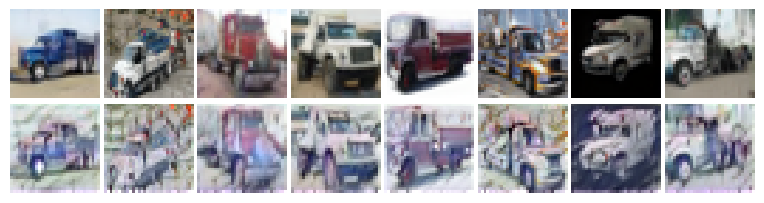

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def show_images(G_orig, G_adapt=None, class_name="dog", num_images=8, seed=42):
    """
    Показывает изображения:
    - Если G_adapt=None: только оригинальные изображения
    - Если G_adapt задан: оригинал (верхний ряд) + адаптация (нижний ряд)
    """
    torch.manual_seed(seed)
    z = torch.randn(num_images, G_orig.z_dim, device=device)
    class_idx = CIFAR10_CLASSES[class_name]
    c = F.one_hot(
        torch.full((num_images,), class_idx, dtype=torch.long, device=device),
        num_classes=10
    ).float()

    with torch.no_grad():
        w = G_orig.mapping(z, c)
        imgs_orig = G_orig.synthesis(w, noise_mode='random')

        if G_adapt is not None:
            w_adapt = G_adapt.mapping(z, c)
            imgs_adapt = G_adapt.synthesis(w_adapt, noise_mode='random')

    # Определяем количество рядов
    rows = 2 if G_adapt is not None else 1
    fig, axes = plt.subplots(rows, num_images, figsize=(num_images * 1.2, rows * 1.2))

    # Верхний ряд: оригинал
    for i in range(num_images):
        ax = axes[0, i] if rows > 1 else axes[i]
        img = imgs_orig[i].permute(1, 2, 0).cpu().numpy()
        img = np.clip(img * 0.5 + 0.5, 0, 1)
        ax.imshow(img, interpolation='nearest')
        ax.axis('off')

    # Нижний ряд: адаптация (если есть)
    if G_adapt is not None:
        for i in range(num_images):
            ax = axes[1, i]
            img = imgs_adapt[i].permute(1, 2, 0).cpu().numpy()
            img = np.clip(img * 0.5 + 0.5, 0, 1)
            ax.imshow(img, interpolation='nearest')
            ax.axis('off')

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.savefig('/content/comparison.png', dpi=150, bbox_inches='tight', pad_inches=0) # колаб
    plt.show()
    



print("\nСравнение: оригинал vs адаптированная модель")
show_images(G_frozen, G_anime, class_name="truck", num_images=8)